In [5]:
# Import python libraries
import getpass
import json
import os
import pathlib
from glob import glob

# Library to work with tabular data
import pandas as pd

# Library to work with vector data
import geopandas as gpd

import earthpy.appeears as eaapp
import hvplot.pandas 
import hvplot.xarray
import rioxarray as rxr
import xarray as xr # uses numpy
import matplotlib.pyplot as plt

In [6]:
from shapely import wkt

In [7]:
den_hoods = pd.read_csv("https://data.colorado.gov/api/views/wiz6-8ftf/rows.csv?date=20240523&accessType=DOWNLOAD")
den_hoods

,the_geom,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES
0,MULTIPOLYGON (((-104.9981218111261 39.79102217...,11,Chaffee Park,NaN,NaN
1,MULTIPOLYGON (((-104.99817551932136 39.7825648...,62,Sunnyside,NaN,Focus Neighborhood
2,MULTIPOLYGON (((-104.9982032874223 39.76929730...,36,Highland,NaN,NaN
3,MULTIPOLYGON (((-104.96875416136173 39.7910397...,29,Globeville,NaN,Focus Neighborhood
4,MULTIPOLYGON (((-105.00948939245227 39.7539270...,39,Jefferson Park,NaN,Focus Neighborhood
...,...,...,...,...,...
73,MULTIPOLYGON (((-104.99169082474663 39.7522890...,63,Union Station,NaN,NaN
74,MULTIPOLYGON (((-104.97191569485533 39.7703010...,26,Five Points,NaN,Focus Neighborhood
75,MULTIPOLYGON (((-104.86603522693314 39.7984106...,60,Stapleton,NaN,NaN
76,MULTIPOLYGON (((-104.80989798184952 39.7728315...,45,Montbello,NaN,NaN


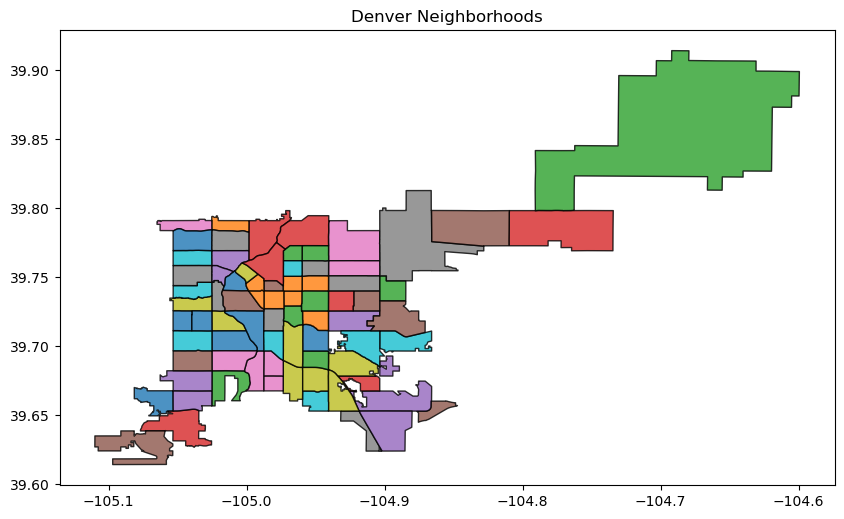

In [4]:
# Step 2: Convert the 'the_geom' column to a GeoSeries
# Assuming 'the_geom' contains WKT format geometries
den_hoods['geometry'] = den_hoods['the_geom'].apply(wkt.loads)

# Step 3: Create a GeoDataFrame
den_hoods_gdf = gpd.GeoDataFrame(den_hoods, geometry='geometry')

# Step 4: Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10,10))
den_hoods_gdf.plot(ax=ax, edgecolor='black', alpha=0.8, column="NBHD_NAME")

plt.title("Denver Neighborhoods")
plt.show()

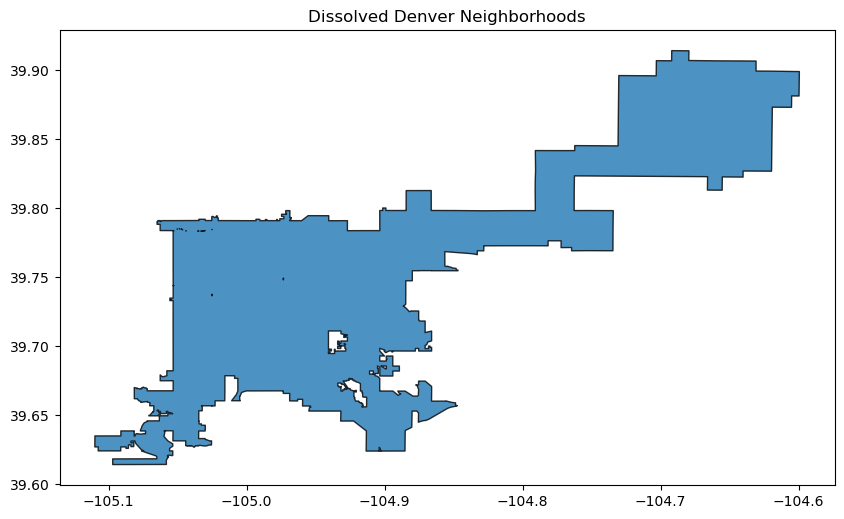

In [8]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# Step 1: Read the CSV data into a pandas DataFrame
den_hoods = pd.read_csv("https://data.colorado.gov/api/views/wiz6-8ftf/rows.csv?date=20240523&accessType=DOWNLOAD")

# Step 2: Convert the 'the_geom' column to a GeoSeries
den_hoods['geometry'] = den_hoods['the_geom'].apply(wkt.loads)

# Step 3: Create a new column with a constant value for all entries
# For example, let's call this column 'dissolve_column' and set it to 1
den_hoods['dissolve_column'] = 1

# Step 4: Create a GeoDataFrame
den_hoods_gdf = gpd.GeoDataFrame(den_hoods, geometry='geometry')

# Step 5: Dissolve the GeoDataFrame into a single polygon
dissolved_gdf = den_hoods_gdf.dissolve(by='dissolve_column')

# Step 6: Plot the dissolved GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
dissolved_gdf.plot(ax=ax, edgecolor='black', alpha=0.8)
plt.title("Dissolved Denver Neighborhoods")
plt.show()


In [2]:
den_hoods_gdf.crs = "EPSG:4326"


In [3]:
print(den_hoods_gdf.crs)

EPSG:4326


In [7]:
# Select Cheesman Park
cheesman = den_hoods_gdf[den_hoods_gdf["NBHD_NAME"] == "Cheesman Park"]
cheesman 

,the_geom,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,geometry
14,MULTIPOLYGON (((-104.9601924942363 39.72910940...,12,Cheesman Park,NaN,NaN,"MULTIPOLYGON (((-104.96019 39.72911, -104.9607..."


In [8]:
cheesman.explore()

In [10]:
data_dir = os.path.join(pathlib.Path.home(), 'cheesman-data')
# Make the data directory
os.makedirs(data_dir, exist_ok=True)

data_dir

'/home/jovyan/cheesman-data'

In [10]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = eaapp.AppeearsDownloader(
    download_key='cheesman-ndvi',
    ea_dir=data_dir,
    product='MOD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date="07-01",
    end_date="07-31",
    recurring=True,
    year_range=[2018, 2023],
    polygon=cheesman
)

ndvi_downloader.download_files(cache=True)

In [11]:
# Get a list of NDVI tif file paths
ndvi_paths = sorted(glob(os.path.join(data_dir, 'cheesman-ndvi', '*', '*NDVI*.tif')))
len(ndvi_paths)

18

In [16]:
scale_factor = 10000
doy_start = -19
doy_end = -12

In [13]:
ndvi_das = []
for ndvi_path in ndvi_paths:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Multiple by scale factor
    da = da / scale_factor

    # Prepare for concatenation
    ndvi_das.append(da)

len(ndvi_das)

18

In [14]:
ndvi_das

[<xarray.DataArray 'NDVI' (date: 1, y: 7, x: 8)>
 array([[[0.2359, 0.2737, 0.3821, 0.3553, 0.3553, 0.3655, 0.2552, 0.2392],
         [0.2917, 0.3228, 0.295 , 0.295 , 0.4638, 0.4638, 0.3491, 0.3491],
         [0.4899, 0.4899, 0.4899, 0.7439, 0.6639, 0.514 , 0.514 , 0.4447],
         [0.3796, 0.3796, 0.4899, 0.7071, 0.7439, 0.5854, 0.5854, 0.405 ],
         [0.4748, 0.4748, 0.4748, 0.7828, 0.6648, 0.6648, 0.6091, 0.5269],
         [0.3681, 0.367 , 0.6918, 0.7456, 0.7456, 0.7878, 0.6632, 0.6494],
         [0.5267, 0.5636, 0.6344, 0.6344, 0.6801, 0.7032, 0.641 , 0.6494]]],
       dtype=float32)
 Coordinates:
     band         int64 1
   * x            (x) float64 -105.0 -105.0 -105.0 ... -105.0 -105.0 -105.0
   * y            (y) float64 39.74 39.74 39.74 39.73 39.73 39.73 39.73
     spatial_ref  int64 0
   * date         (date) datetime64[ns] 2018-06-26,
 <xarray.DataArray 'NDVI' (date: 1, y: 7, x: 8)>
 array([[[0.3116, 0.3116, 0.3227, 0.3227, 0.3227, 0.3076, 0.2798, 0.2883],
         [0.

In [15]:
ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
ndvi_da

<xarray.Dataset>
Dimensions:      (x: 8, y: 7, date: 18)
Coordinates:
    band         int64 1
  * x            (x) float64 -105.0 -105.0 -105.0 ... -105.0 -105.0 -105.0
  * y            (y) float64 39.74 39.74 39.74 39.73 39.73 39.73 39.73
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2018-06-26 2018-07-12 ... 2023-07-28
Data variables:
    NDVI         (date, y, x) float32 0.2359 0.2737 0.3821 ... 0.5973 0.5532

In [16]:
# Compute the difference in NDVI before and after the fire
ndvi_diff = (
    ndvi_da
        .sel(date=slice('2021', '2023'))
        .mean('date')
        .NDVI 
   - ndvi_da
        .sel(date=slice('2018', '2020'))
        .mean('date')
        .NDVI
)

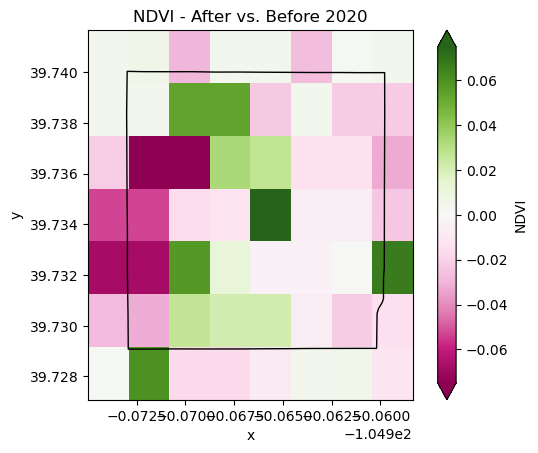

In [17]:
# Plot the difference
fig, ax = plt.subplots()

ndvi_diff.plot(x='x', y='y', cmap='PiYG', robust=True, ax=ax)
cheesman.plot(edgecolor='black', color='none', ax=ax)
plt.title("NDVI - After vs. Before 2020")
plt.show()

In [11]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = eaapp.AppeearsDownloader(
    download_key='denver-ndvi',
    ea_dir=data_dir,
    product='MOD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date="07-01",
    end_date="07-31",
    recurring=True,
    year_range=[2018, 2023],
    polygon=dissolved_gdf
)

ndvi_downloader.download_files(cache=True)

In [14]:
# Get a list of NDVI tif file paths
ndvi_paths = sorted(glob(os.path.join(data_dir, 'denver-ndvi', '*', '*NDVI*.tif')))
len(ndvi_paths)

18

In [17]:
ndvi_das = []
for ndvi_path in ndvi_paths:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Multiple by scale factor
    da = da / scale_factor

    # Prepare for concatenation
    ndvi_das.append(da)

len(ndvi_das)

18

In [18]:
ndvi_das

[<xarray.DataArray 'NDVI' (date: 1, y: 145, x: 246)>
 array([[[0.2408, 0.2408, 0.2408, ..., 0.2445, 0.2159, 0.2345],
         [0.2628, 0.2628, 0.2628, ..., 0.2445, 0.2087, 0.2087],
         [0.1986, 0.2323, 0.2628, ..., 0.2475, 0.2088, 0.2088],
         ...,
         [0.4649, 0.5309, 0.5309, ..., 0.257 , 0.2779, 0.2924],
         [0.4964, 0.5243, 0.5243, ..., 0.257 , 0.2934, 0.294 ],
         [0.4381, 0.4381, 0.4381, ..., 0.2585, 0.2737, 0.292 ]]],
       dtype=float32)
 Coordinates:
     band         int64 1
   * x            (x) float64 -105.1 -105.1 -105.1 ... -104.6 -104.6 -104.6
   * y            (y) float64 39.91 39.91 39.91 39.91 ... 39.62 39.62 39.62 39.61
     spatial_ref  int64 0
   * date         (date) datetime64[ns] 2018-06-26,
 <xarray.DataArray 'NDVI' (date: 1, y: 145, x: 246)>
 array([[[0.2115, 0.3197, 0.3197, ..., 0.2173, 0.2202, 0.214 ],
         [0.1675, 0.1675, 0.2442, ..., 0.2444, 0.2121, 0.2121],
         [0.1246, 0.1131, 0.1466, ..., 0.226 , 0.1958, 0.1958],
    

In [19]:
ndvi_da = xr.combine_by_coords(ndvi_das, coords=['date'])
ndvi_da

<xarray.Dataset>
Dimensions:      (x: 246, y: 145, date: 18)
Coordinates:
    band         int64 1
  * x            (x) float64 -105.1 -105.1 -105.1 ... -104.6 -104.6 -104.6
  * y            (y) float64 39.91 39.91 39.91 39.91 ... 39.62 39.62 39.62 39.61
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2018-06-26 2018-07-12 ... 2023-07-28
Data variables:
    NDVI         (date, y, x) float32 0.2408 0.2408 0.2408 ... 0.5164 0.5235

In [20]:
# Compute the difference in NDVI before and after the fire
ndvi_diff = (
    ndvi_da
        .sel(date=slice('2021', '2023'))
        .mean('date')
        .NDVI 
   - ndvi_da
        .sel(date=slice('2018', '2020'))
        .mean('date')
        .NDVI
)

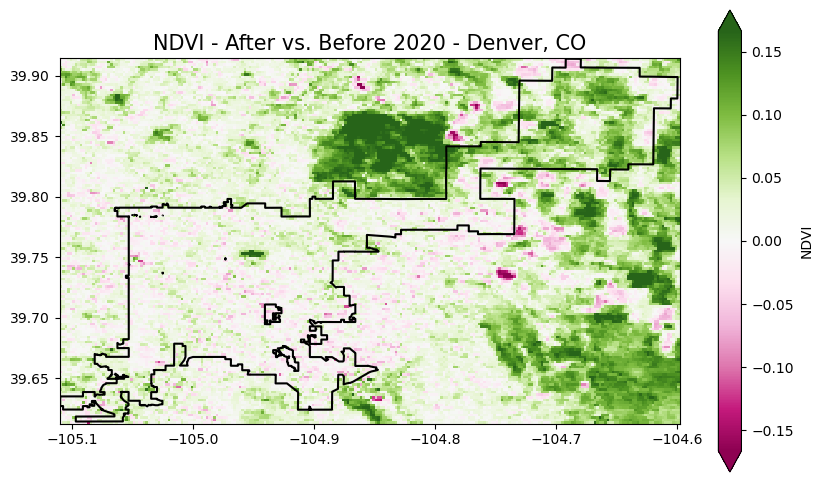

In [29]:
# Plot the difference
fig, ax = plt.subplots(figsize=(10,6))

ndvi_diff.plot(x='x', y='y', cmap='PiYG', robust=True, ax=ax)
dissolved_gdf.plot(edgecolor='black', color='none', ax=ax, linewidth=1.5)

# Turn off x and y axis titles
ax.set_xlabel('')
ax.set_ylabel('')

plt.title("NDVI - After vs. Before 2020 - Denver, CO", fontsize=15)
plt.show()